# Advanced Modeling and Simulation Course
### Instructor: Dr. M. Nedim ALPDEMİR

# Continuous Simulation

The second part of the exercises contains examples of **Continuous Simulation**.
For this part we use an open source Continuous Simulation package written in Python called __SimuPy__

## Obtaining SimuPy

[SimuPy packages are available from https://github.com/simupy/simupy](https://github.com/simupy/simupy). The project website is at [https://simupy-personal.readthedocs.io/en/latest/index.html](https://simupy-personal.readthedocs.io/en/latest/index.html)




## Brief introduction to SimuPy Basic Concepts

* SimuPy is a framework for simulating interconnected dynamical system models and provides an open source, python-based tool that can be used in model- and system- based design and simulation workflows. 
* Dynamical system models can be specified as an object with the interface described in the API Documentation. Models can also be constructed using symbolic expressions

### Mathematical Formulation of a System

<p>SimuPy assumes systems have no direct feedthrough between inputs and outputs;
this discpline avoids algebraic loops. You can simulate a system model that
includes a feedthrough by augmenting the system. Augment the system using the
input by including input components in the state and using derivatives of those
signals in the control input. You can augment the system using the output by
including the original output components in the state and using integrals of
those signals in the system output. However, there is no requirement for the
system to have a state, so</p>

<div class="math notranslate nohighlight">
\[\begin{split}x'(t) = f(t,x(t),u(t)) \\
y(t) = h(t,x(t))\end{split}\]</div>
<p>and</p>
<div class="math notranslate nohighlight">
\[y(t) = h(t,u(t))\]</div>

<p>are both valid formulations. Here, <span class="math notranslate nohighlight">\(t\)</span> is the time variable, <span class="math notranslate nohighlight">\(x\)</span>
is the system state, <span class="math notranslate nohighlight">\(u\)</span> is the system input, and <span class="math notranslate nohighlight">\(y\)</span> is the sytem
output. We call <span class="math notranslate nohighlight">\(f\)</span> the state equation and <span class="math notranslate nohighlight">\(h\)</span> the output equation.


SimuPy can also handle discrete-time systems with sample period <span class="math notranslate nohighlight">\(\Delta t\)</span>
of the form</p>

<div class="math notranslate nohighlight">
\[\begin{split}x[k+1] = f([k],x[k],u(k)]) \\
y[k+1] = h([k],x[k+1])\end{split}\]</div>
<p>and</p>
<div class="math notranslate nohighlight">
\[y[k+1] = h([k], u(k))\]</div>

<p>where <span class="math notranslate nohighlight">\([k]\)</span> indicates signal values over the half-open interval
<span class="math notranslate nohighlight">\((k\, \Delta t, (k+1) \Delta t]\)</span> which are updated at time
<span class="math notranslate nohighlight">\(t=k\, \Delta t\)</span> for discrete-time systems and <span class="math notranslate nohighlight">\((k)\)</span> indicates a zero-order hold sample of the signal at time <span class="math notranslate nohighlight">\(k \, \Delta t\)</span> for continuous-time systems. This formulation gives the expected results for models
with only discrete-time sub-systems of the same update rate <span class="math notranslate nohighlight">\(\Delta t\)</span>
which can be combined into a single system of the form</p>
<div class="math notranslate nohighlight">
\[\begin{split}x[k+1] = f([k], x[k], u[k]) \\
y[k]= h([k], x[k])\end{split}\]</div>
<p>and makes sense in general for hybrid-time simulation.</p>


The examples in this part start with a relatively simple problem and increase in complexity as we move forward.

## Pendulum example


![image.png](pendulum-pic.png) 


This is a free body diagram. Pendulum has a mass (m), a length (l) and the gravity (g) is acting on it. It makes an angle (x) with the normal to the ceiling when it swings.

### In the form of a block diagram form this becomes


![image.png](pendulum-block.png)

The top block represents the inertia. The state of the system consists of position and velocity. The input to the block is a force acting on the joint.  The position and velocity are the output of the block. We connect this block to a model of gravity which is a position dependent force.

In [4]:
import numpy as np 
import sympy as sp
import matplotlib.pyplot as plt
from simupy.systems.symbolic import DynamicalSystem, dynamicsymbols
from simupy.block_diagram import BlockDiagram
from simupy.array import Array, r_

def shape_figure():
    fig = plt.gcf()
    fig.set_size_inches(10,6, forward = True)
    fig.legend(loc='upper right', bbox_to_anchor=(1.1,1.0)) 
    fig.tight_layout()
    
def plot_x(result, label = ''):
    plt.plot(result.t, result.y[:,0]*180/np.pi, label = label)
    plt.xlabel('time, s')
    plt.ylabel('position, degrees')

In [5]:
# now define the system in SimuPy
# signals, state variables etc.
x, v, u = dynamicsymbols('x v u')

l, m = sp.symbols('l m')
parameters = {l:1, m:1}

inertia = DynamicalSystem(
    state_equation = r_[v,u / (m*l**2)],
    state = r_[x, v],
    input_ = u, 
    constants_values = parameters
)

g = sp.symbols('g')
parameters[g] = 9.8
gravity = DynamicalSystem(
    output_equation = -g*m*l*sp.sin(x),
    input_ = x,
    constants_values = parameters
)



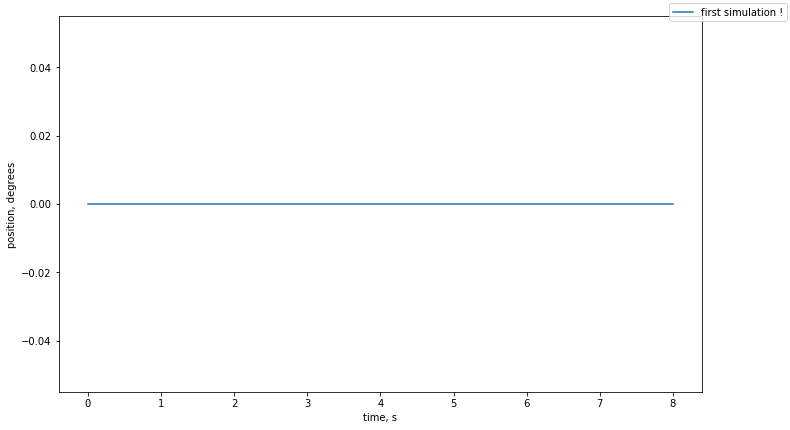

In [6]:
# now put them together

BD = BlockDiagram(inertia, gravity)
BD.connect(gravity, inertia)
BD.connect(inertia, gravity, outputs=[0])
inertia.initial_condition = np.r_[0*np.pi/180,0]
plt.figure()
plot_x(BD.simulate(8), 'first simulation !')
shape_figure()
plt.savefig('first_sim.pdf')

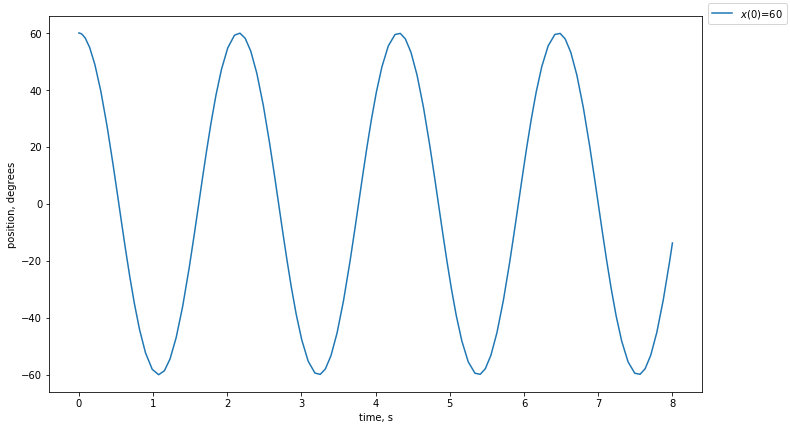

In [7]:
inertia.initial_condition = np.r_[60*np.pi/180,0]
plot_x(BD.simulate(8), '$x(0)$=60')
shape_figure()
plt.savefig('reaally.pdf')

![image.png](pendulum-block-lin.png)

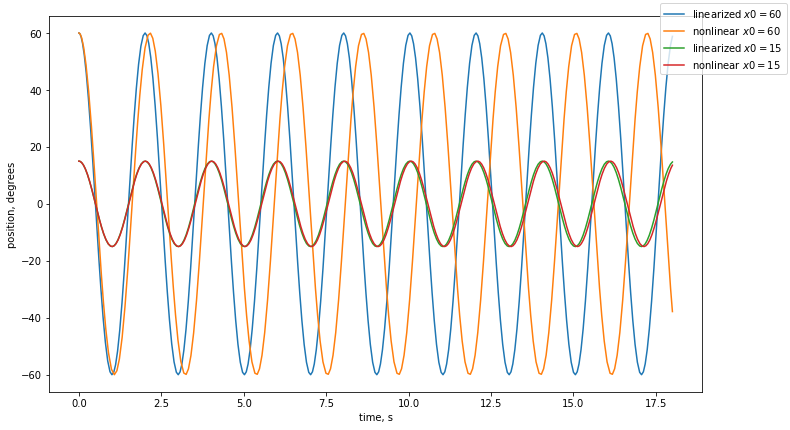

In [8]:
linearized_gravity = DynamicalSystem(
    output_equation = -g*m*x/l,
    input_ = x,
    constants_values = parameters
)
BD.add_system(linearized_gravity)
BD.connect(inertia, linearized_gravity, outputs=[0])
plt.figure()
for x0 in [60, 15]:
    inertia.initial_condition[0] = x0*np.pi / 180
    BD.connect(linearized_gravity, inertia)
    plot_x(BD.simulate(18), 'linearized $x0 = $%d'%x0)
    
    BD.connect(gravity, inertia)
    plot_x(BD.simulate(18), 'nonlinear $x0 = $%d'%x0)
shape_figure()

![image.png](pendulum-block-damping.png)

In [9]:
b = sp.symbols('b')
parameters[b] = 1.0
viscous_damping = DynamicalSystem(
    output_equation = -b*v,
    input_ = v,
    constants_values = parameters
)

print(parameters)
print(inertia.initial_condition)
#inertia.initial_condition = np.r_[60*np.pi/180,0,60*np.pi/180,0]

{l: 1, m: 1, g: 9.8, b: 1.0}
[0.26179939 0.        ]


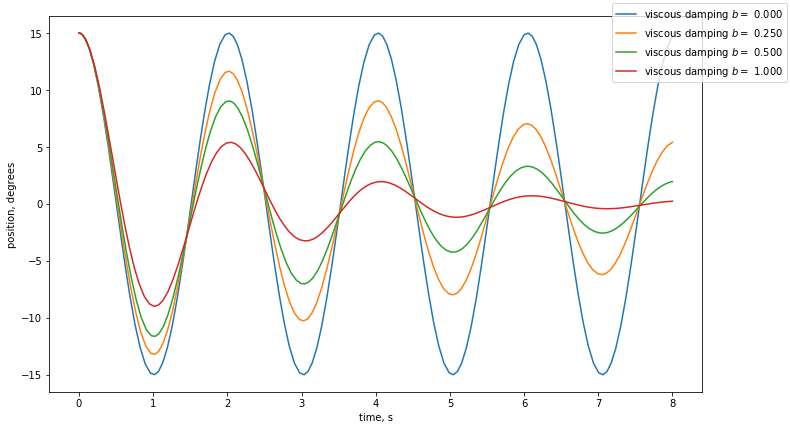

In [10]:
from simupy.systems import LTISystem
sum1 = LTISystem(np.ones((1,5)))

BD = BlockDiagram(inertia, sum1, gravity, viscous_damping)
BD.connect(inertia, viscous_damping, outputs = [1])
BD.connect(sum1,inertia)
BD.connect(gravity, sum1, inputs = [0])
BD.connect(inertia, gravity, outputs = [0])
BD.connect(viscous_damping, sum1, inputs = [1])

plt.figure()
for bval in [0, 0.25, 0.5, 1.0]:
    parameters[b] = bval
    t= BD.simulate(8)
    plot_x(t,'viscous damping $b=$%6.3f' % bval)
shape_figure()
plt.savefig('damped.pdf')